In [1]:
%matplotlib inline
import numpy as n
import matplotlib.pyplot as p
import numpy.fft as fft
import scipy.signal as signal
import cosmology as cosmo

0.048252


In [2]:
def readCSTFile(fname):
    traces=[]
    titles=[]
    ntraces=0
    f=open(fname)
    lines=f.readlines()
    nline=len(lines)
    for lnum,line in enumerate(lines):
        entry=line.split()
        if '/' in line or lnum==nline-1:
            if(len(entry)>=1):
                titles.append(entry[-2]+entry[-1])
                #titles.append(entry[-2])

            if(ntraces>0):
                traces.append(n.array(data))
                if(n.mod(len(traces[-1]),2)==1):
                    #traces[-1]=traces[-1][:-1]
                    dt=traces[-1][1,0]-traces[-1][0,0]
                    traces[-1][:,0]+=dt
                    traces[-1]=n.vstack([n.zeros((1,2)),traces[-1]])
            data=[]
            ntraces+=1
        elif(len(entry)==2):
            data.append([float(entry[0]),float(entry[1])])
    f.close()
    return traces,titles

def readVNA(fname,flow=100.,fhigh=200.):
    data=n.loadtxt(fname,skiprows=9,delimiter=',')
    nf=len(data)
    fAxis=n.arange(nf)*(fhigh-flow)/nf+flow
    return fAxis,data[:,0]+1j*data[:,1]


In [3]:
traceListFeedAndDishCylinderBackPlane=readCSTFile('../data/timetraces/paper_dipole_cylinder_backplane_timetrace.txt')
traceListFeedAndDishBackPlane=readCSTFile('../data/timetraces/paper_dipole_backplane_timetrace.txt')
traceListFeedAndDishBareDipole=readCSTFile('../data/timetraces/paper_dipole_bareDipole_timetrace.txt')
traceListFeedAndDishPaneledDipole=readCSTFile('../data/timetraces/paper_dipole_paneled_feed_timetrace.txt')

In [4]:

lines=[]
def plotTraces(traceList,flow,fhigh,titleList=['o1','Planewave'],ls='-',lastPlot=True,translate=0.,labels=[],colors=['k'],xlims=[-300,300],ylims=[-70,0]):
    nt=len(traceList[0])
    dt=traceList[0][1,0]-traceList[0][0,0]
    print nt
    print dt
    iInd=0
    oInd=0
    #determine whether plane wave or i1    
    while('Planewave' not in titleList[iInd] and 'i1' not in titleList[iInd]):
        iInd+=1
    while('o1' not in titleList[oInd]):
        oInd+=1
    
    for mm in range(len(flow)):
        pwPadTimeSimulation=n.pad(traceList[iInd][:,1],(int(nt*.5),int(nt*.5)),mode='constant')
        vrPadTimeSimulation=n.pad(traceList[oInd][:,1],(int(nt*.5),int(nt*.5)),mode='constant')
        fAxisPadTimeSimulation=(fft.fftfreq(len(vrPadTimeSimulation),dt))
        fWaveTimeSimulation=fft.fft(fft.fftshift(pwPadTimeSimulation))
        fResponseTimeSimulation=fft.fft(fft.fftshift(vrPadTimeSimulation))
        dfTimeSimulation=fAxisPadTimeSimulation[1]-fAxisPadTimeSimulation[0]

        selectionPos=n.logical_and(fAxisPadTimeSimulation>=flow[mm]/1e3,fAxisPadTimeSimulation<=fhigh[mm]/1e3)
        selectionNeg=n.logical_and(-fAxisPadTimeSimulation>=flow[mm]/1e3,-fAxisPadTimeSimulation<=fhigh[mm]/1e3)
        nSelect=len(fAxisPadTimeSimulation[selectionPos])
        print nSelect
        #windowTimeSimulation=n.hamming(nSelect)
        windowTimeSimulation=signal.blackmanharris(nSelect)
        windowTimeSimulation=windowTimeSimulation/windowTimeSimulation.mean()
        windowTimeSimulationFull=n.zeros(2*nt)
        windowTimeSimulationFull[selectionPos]=windowTimeSimulation
        windowTimeSimulationFull[selectionNeg]=windowTimeSimulation
        delayResponseTimeSimulation=fft.fftshift(fft.ifft(fft.fftshift((windowTimeSimulationFull*fResponseTimeSimulation/fWaveTimeSimulation)[selectionPos])))
        tAxisTimeSimulation=fft.fftshift(fft.fftfreq(len(delayResponseTimeSimulation),dfTimeSimulation))

    #use kparallel
        littleh=.68
        kParaTimeSimulation=cosmo.eta2kpara(tAxisTimeSimulation/1e9-35e-9,cosmo.f2z((fhigh[mm]-flow[mm])/2.*1e6+flow[0]*1e6))/littleh
        #kParaMeasured=cosmo.eta2kpara(tAxisMeasured/1e9,cosmo.f2z((fhigh[mm]-flow[mm])/2.*1e6+flow[0]*1e6))/littleh

        responseSimulatedKernel=signal.fftconvolve(delayResponseTimeSimulation,n.conj(delayResponseTimeSimulation)[::-1],mode='same')
        try:
            label=labels[mm]
        except:
            label='%d-%d MHz'%(flow[mm],fhigh[mm])
        try:
            color=colors[mm]
        except:
            color='k'
        #p.plot(tAxisTimeSimulation,10.*n.log10(n.abs(responseSimulatedKernel)/n.abs(responseSimulatedKernel).max()),'-o',label='Simulation, Zenith',markersize=4,lw=2)
        if(fhigh[mm]-flow[mm]>50):
            lw=4
            lines.append(p.plot(tAxisTimeSimulation-translate,10.*n.log10(n.abs(delayResponseTimeSimulation)/n.abs(delayResponseTimeSimulation).max()),'-o',color=color,label=label,markersize=4,lw=lw,ls=ls)[0])

        else:
            lw=2
            lines.append(p.plot(tAxisTimeSimulation-translate,10.*n.log10(n.abs(delayResponseTimeSimulation)/n.abs(delayResponseTimeSimulation).max()),'-o',label=label,markersize=4,lw=lw,ls=ls)[0])

    if(lastPlot):
        #p.gca().set_xticks(n.arange(-140,500,30))
        p.gca().tick_params('x',labelsize=22)
        p.gca().tick_params('y',labelsize=22)
        p.grid()
        p.legend(loc='best',fontsize=22)
        p.xlim(xlims)
        p.ylim(ylims)
        ax1=p.gca()
        ax2=p.gca().twiny()
        ax2.set_xticks(ax1.get_xticks())
        ax2.set_xlim(ax1.get_xlim())
        ticklabels=[]
        for tick in ax2.get_xticks():
            ticklabels.append('%.2f'%(cosmo.eta2kpara(tick/1e9,cosmo.f2z(150e6))/littleh))

        ax2.set_xticklabels(ticklabels)
        ax2.tick_params('x',labelsize=22)
        ax2.set_xlabel('$k_{\\parallel}$ ($h$Mpc$^{-1}$)',fontsize=25)
        ax1.set_xlabel('$\\tau$ (ns)',fontsize=25)
        ax1.set_ylabel('Voltage Response (dB)',fontsize=25)
        p.gcf().set_size_inches([14,10])



7920
0.17953958
227
7724
0.10071734
125
7584
0.043790221
53
7726
0.07669872
95


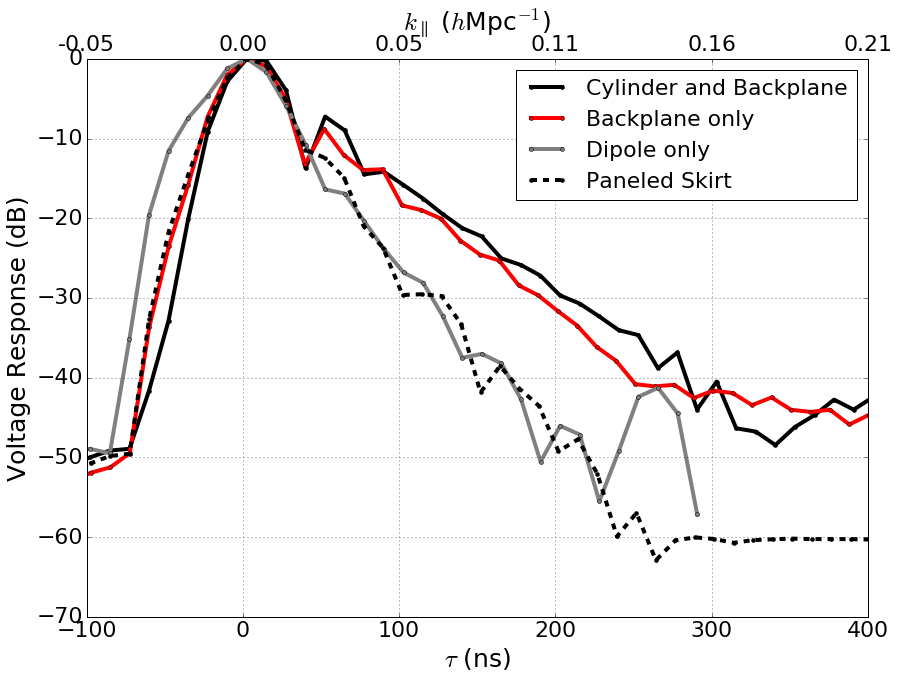

In [5]:
flow=[50]
fhigh=[130]
plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])
#flow=[50]
#fhigh=[150]
#plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])
plotTraces(traceListFeedAndDishBackPlane[0],flow,fhigh,traceListFeedAndDishBackPlane[1],lastPlot=False,translate=35.,labels=['Backplane only'],colors=['red'],xlims=[-100,400])
plotTraces(traceListFeedAndDishBareDipole[0],flow,fhigh,traceListFeedAndDishBareDipole[1],lastPlot=False,translate=35.,labels=['Dipole only'],colors=['grey'],xlims=[-100,400])
plotTraces(traceListFeedAndDishPaneledDipole[0],flow,fhigh,traceListFeedAndDishPaneledDipole[1],lastPlot=True,translate=35.,labels=['Paneled Skirt'],colors=['k'],xlims=[-100,400],ls='--')


p.savefig('../compare_Traces.pdf')



